In [1]:
%autosave 0

import os
from rich.jupyter import print
from dharpa_toolbox.modules.utils import list_available_module_names, describe_module, print_module_desc, load_workflows, create_module
from dharpa_toolbox.utils import print_file_content, graph_to_image
from dharpa_toolbox.modules.workflows import DharpaWorkflow
from dharpa_toolbox.rendering.jupyter.renderer import PlainJupyterWorkflowRenderer, ModuleJupyterWorkflowRenderer

base_path = os.path.abspath(".")

Autosave disabled


## What's a workflow, really?

- Jupyter is a very good tool to create non-trivial exploratory workflows
- there's a difference between 'dynamic' workflows, and 'static' ones
- Jupyter is usually used to create workflows in a 'dynamic' way
- also important (for us): interactivity


Currently, Jupyter is one of the most used technologies in digital research to create workflows. Although there are exceptions,
in most cases it is used to explore a very specific research question. Jupyter is exceptionally good at that, which is the
reason it is so successful.

From a computer-engineering perspective, Jupyter notebooks are 'just' simple scripts, and often they include anti-patterns like
global- as well as hard-coded variables, little to no encapsulation of functionality, etc. Which means that typically,
Jupyter notebooks have (relatively) little value to other researchers, and re-usability is low. This is an acceptable
trade-off though, because the problems they are solving are (usually) very niche and specific, so there is little downside
to tailor the code to the exact problem one is having. In addition, Jupyter notebooks are very good to document the workflow
itself, and communicate what is happening to the data (which is important for publication).

If we want to create a tool that lets users run pre-created workflows, that equation changes though. Because, now the assumption
is that the (comparatively few) workflows we create will be useful in not just a very specific way. The goal is to identify
areas where people have (roughly) the same problem, and to solve that problem in a generic way that is useful to a
larger group of people. The workflow will typically be less important in relation to the overall research project a
researcher is working on (compared to a tailored, specific one), but from the perspective of a reasearcher it will also be
much less hassle and expensive to use, since they don't have to create the workflow themselves, and someone else already
has thought about all the options and parameters that make sense, has done the validation and testing, etc. Also, they
don't have to learn programming if they don't already know it...

This means that we are dealing now with a very 'static' workflow, compared to the 'dynamic' ones researchers with programming
skills can create and change themselves very easily. Everything that can happen in a workflow is known in advance, and
even though there can be 'forks' in the flow of data, those have to be defined, implemented and documented in advance.
And that difference is why we should not assume that Jupyter notebooks are as good a vessel to implement such a workflow
as they are in the other case, where all that can happen 'on the go'. It's still possible notebooks are a good fit here too,
but we can't use our normal experience with -- and intuition about -- Jupyter to make that case.

One other point that is important to note is user interactivity. Usually, when developing a Jupyter notebook inputs (data as well
as parameters) are either hardcoded, or factored out into a variable that is changed on top of the notebook (or in some cells
further down). And by running or re-running certain cells, those variables are re-set or changed. This works fine for
dynamically creating a workflow (although, it's sometimes confusing, and one of the main criticisms against the Jupyter notebook
approach). But, in a 'static' workflow, we need to make sure that a user can set or change all those inputs at any time, while
making sure that the 'internal' state of our workflow is known to our engine. At a minimum, we need to know that our state
is currently inconsistent after a user-input, and have a way to communicating that to the user so they can kick off
some re-processing manually, to make it consistent again. Jupyter supports interactivity via widgets, but the 'cell-based'
approach in notebooks is not a very good fit for that, because it forces a very simple one-after-the other processing model,
that would make it hard to implement the efficient execution of even remotely non-trivial workflows (for example having
parallel execution of some cells, or skipping the execution of parts that don't need to be executed currently, etc.).

## Prior art

- workflow/pipeline modelling and execution is a solved problem in programming:
  - [flow-based programming (FBP)](https://en.wikipedia.org/wiki/Flow-based_programming)
  - requires well defined, modular entities (with 'ports': input and output values)
- lots of (partial) implementations in data engineering:
  - [airflow](https://airflow.apache.org/)
  - [luigi](https://github.com/spotify/luigi)
  - [dagster](https://github.com/dagster-io/dagster)
  - [prefect](https://www.prefect.io/)
  - many others: Node-RED, Apache NiFi, IFTTT, Zapier, Huginn, ...
- one subtle (although important) difference with our project, again: interactivity

There is a form of programming that fits our problem space fairly well: [flow-based programming (FBP)](https://en.wikipedia.org/wiki/Flow-based_programming).
Like functional programming, it's probably older than all of us, and it is gaining some notable traction again in recent years
(although with much less hype around it, and without being explicitly mentioned by name). A lot of the data orchestration
tools and frameworks that cropped up in recent years use some form or aspects of FBP, for example:

  - [airflow](https://airflow.apache.org/)
  - [luigi](https://github.com/spotify/luigi)
  - [dagster](https://github.com/dagster-io/dagster)
  - [prefect](https://www.prefect.io/)

One thing that FBP requires are well defined entities ('modules', 'nodes'), that have 'ports' (meaning: known inputs, and outputs).
A Jupyter notebook for example does not typically have that, which makes it hard to 'combine' notebooks in an FBP-like
manner. There are attempts to 'formalize' Jupyter notebooks in a way that would make them better fits in such scenarios
([papermill](https://papermill.readthedocs.io/en/latest/), [orchest](https://www.orchest.io/)), but in my opinion, although
 they kind of work, those attempts are a bit clunky, and not very user-friendly (because they try to bend Jupyter into
 something it was not designed to do). Also, they typically only deal with inputs; outputs are not very well defined at all.
 Compare that for example with how a 'proper' data-orchestration tool like dagster handles [inputs and outputs](https://docs.dagster.io/tutorial/basics_solids),
which should make clear how many more options someone who implements a workflow execution and rendering framework (which
is basically what we are building) has when that sort of metadata is available.


As was the case in the section above, one difference in our case is interactivity. Most tools in that space assume they'll
get the input values for a workflow execution at the start, and then they can proceed to go through the workflow, batch-processing
style (meaning, no further user input half-way through). This is different for us, since we want users to be able to
interactively explore their data (within the limits of a 'static' workflow). This means we will have to consider how
to deal with long-running computations whose results wil be available after minutes, hours weeks. The good thing is though,
whatever we come up with, we'll get a 'traditional workflow execution engine' for free, because every workflow that can
be executed interactively, will also be able to do 'batch-style'. This will let us re-use and 'move' our workflows to
other execution environments (HPC clusters, 'the cloud', ...) and do other interesting things with them if the need arises
(monte-carlo style experiments, automated-testing of workflows and modules, ...).

## Modelling workflows

- research data is more useful when it's structured, so why would workflow definitions be different?
- so: can we model a workflow as code, or even better: as data?

So, assuming everyone agrees this is a reasonable avenue to explore, we have to think about how we want to model our
workflows. We should definitely look at how other, similar frameworks do this, but I think one approach is very tempting:

> ***Describe workflows as structured data!***

There are several reasons for why I think this would be a good idea:

- structured data can be processed by every programming language in existence
   - we would have one 'main' library that does the actual workflow execution/data processing (probably in Python)
   - we could use other languages to do different other things in our 'ecosystem': e.g. JavaScript for dynamically rendering a frontend
- we can (largely) work independent from each other, the only thing to consult about is the schema of the workflow data
- such structured data can be displayed as a network graph, which is much easier to grasp than code
- automated testing of every workflow and model is easy, can be done in CI/CD
- Jupyter notebooks are, as I've explained above, pretty good at creating and manipulating structured data
- there are a lot of researchers out there who know how to use Jupyter: those could all be potential "DHARPA-workflow" creators
- in addition to that, we can decide to create a visual 'workflow editor/creator', that is independent from the 'workflow executor' part, and 100% optional


## Code!

The following is using prototype-quality code to illustrate how a 'workflow-as-data' model could look like in practice. Only a few modules are implemented, the goal is to recreate the first part of the 'Topic-modelling' workflow: load some text files, tokenize them, then do some processing (lowercasing, removal of stopwords).

### Definitions

- ***module***: a module is an atomic entity that contains a fixed set of defined inputs and outputs, as well as a processing unit that converts the set of inputs to outputs, in a predicable way

- ***workflow***: a workflow contains a set of modules which are connected in a specific way. A workflow is conceptually also a module, because it also contains a set of inputs/outputs as well as processing unit, and it can be used in other, 'parent' workflows in the same ways a normal module can.

In [2]:
# we can list all available modules (and workflows)
list_available_module_names()

['dharpa_workflow',
 'file_reader',
 'lowercase_corpus',
 'remove_stopwords_from_corpus',
 'tokenize_corpus']

In [3]:
# we can investigate each modules inputs and output specs
print_module_desc('tokenize_corpus')

In [4]:
# a workflow configuration is basically just a list of modules, incl. their input/output connections
workflow_config = f'{base_path}/workflows/corpus_processing_simple.yaml'
print_file_content(workflow_config)

```yaml
---
modules:

- type: tokenize_corpus

- type: lowercase_corpus
  input_map:
    tokenized_text: tokenize_corpus.tokenized_text

- type: remove_stopwords_from_corpus
  input_map:
    tokenized_text: lowercase_corpus.tokenized_text
  workflow_outputs:
    tokenized_text: processed_text_corpus
```

In [5]:
# we create a 'workflow' object using the configuration data
workflow: DharpaWorkflow = DharpaWorkflow.from_file(workflow_config)
# we can investigate each workflows available input and output names
print(workflow.input_names)

In [6]:
print(workflow.output_names)

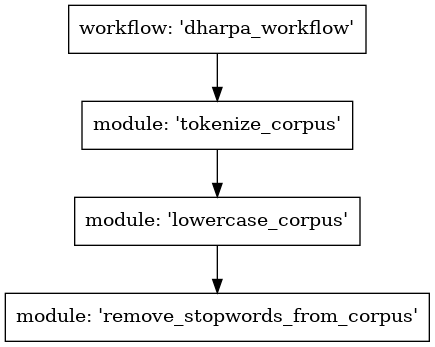

In [7]:
# we can display the execution and data-flow structures of a workflow graphically
graph_to_image(workflow.execution_graph)
# graph_to_image(workflow.data_flow_graph)

In [8]:
# print the workflow input/output spec
print_module_desc(workflow)

In [9]:
# using the spec, we can set a workflows inputs and outputs manually
text_map = {
    "1": "Hello World!",
    "2": "Hello DHARPA!"
}
stopwords = [
    "hello",
    "!"
]
workflow.set_input("tokenize_corpus__text_map", text_map)
workflow.set_input("lowercase_corpus__enabled", True)
workflow.set_input("remove_stopwords_from_corpus__enabled", True)
workflow.set_input("remove_stopwords_from_corpus__stopwords_list", stopwords)

# the workflow state is processed automatically, so we can always query the current output
output1 = workflow.get_output("processed_text_corpus")
print(output1)

In [10]:
# we can load workflows from json/yaml files on the file-system, and convert them to Python classes
load_workflows(f"{base_path}/workflows")
print(list_available_module_names())

In [11]:
# display the module spec for the 'input_files_processing' workflow
print_module_desc("input_files_processing")

In [12]:
# create the workflow object
ifp_workflow = create_module('input_files_processing')
# display the internal structure of the workflow
print(ifp_workflow._workflow_config)

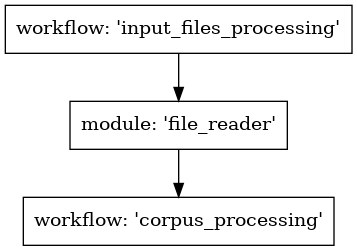

In [13]:
# display the execution graph for the workflow
graph_to_image(ifp_workflow.execution_graph)
# graph_to_image(ifp_workflow.data_flow_graph)

In [14]:
# auto-render input and output-widgets for the workflow (only works when executed in Jupyter)
renderer = PlainJupyterWorkflowRenderer(workflow=ifp_workflow)
renderer.render()

GridspecLayout(children=(Label(value='files', layout=Layout(grid_area='widget001')), FileUpload(value={}, desc…

Output()

### Advantages

- each interactive workflow is automatically a 'batch-style' one
- ability to work on different parts of the application almost 100% independently (workflow engine, workflow renderers (UIs), plugins (submitting long running jobs to a cluster, metadata augmentation/data lineage, metric gathering, ...)
- comparatively little dependencies for the base system / lightweight, but very extensible
- no dependency on any one UI/frontend technology (can use Jupyter/React/QT/...), can run without any UI at all
- complex workflow can be broken up into separate pieces, and developed and tested individually
- fairly high re-usablity
- easy to use in an agile, iterative development process


### Disadvantages

- potentially lower performance due to having to create copies of inputs/outputs to make sure they (or items contained within them) are not changed by subsequent steps
- harder to create very customized UIs
- there's a limit to the complexity of workflows that can be supported realistically (e.g. hard to implement control structures like if-then-else or loops on a workflow level/outside of modules -- but in a lot of cases that is probably not necessary)